# Імпорти, завантаження і попередня обробка даних

In [ ]:
!pip install scikit-optimize
!pip install tensorflow-text

import pandas as pd
import string
string.punctuation
import re
from nltk.stem import WordNetLemmatizer
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM, Dropout, SimpleRNN, GRU, Embedding, Input, TextVectorization
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from sklearn.metrics import classification_report, confusion_matrix, cohen_kappa_score, ConfusionMatrixDisplay, balanced_accuracy_score, accuracy_score, f1_score, roc_auc_score
from tensorflow.keras.callbacks import TensorBoard, LambdaCallback
import datetime, os
import io
import matplotlib.pyplot as plt
import itertools
import plotly.express as px
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import cohen_kappa_score, make_scorer
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from skopt import BayesSearchCV
import tensorflow_hub as hub
import tensorflow_text as text
import plotly.graph_objs as go

nltk.download('wordnet')

## Набір даних

Завантаження з Диску, попередньо датасет був збережений на Диск:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df_train = pd.read_csv('/content/drive/MyDrive/NTZ_3/drugLibTrain_raw.tsv', sep='\t')
df_test = pd.read_csv('/content/drive/MyDrive/NTZ_3/drugLibTest_raw.tsv', sep='\t')

In [ ]:
df = pd.concat([df_train, df_test])

Видалили непотрібні стовпці:

In [ ]:
df.drop(['Unnamed: 0.1', 'Unnamed: 0'], axis=1, inplace=True)

Шукаємо NaN-и:

In [ ]:
for column_name in df.columns:
  count_na = df[df[column_name].isna()].shape[0]
  print(f"{column_name} has {count_na} NaN values")

urlDrugName has 0 NaN values
rating has 0 NaN values
effectiveness has 0 NaN values
sideEffects has 0 NaN values
condition has 1 NaN values
benefitsReview has 0 NaN values
sideEffectsReview has 2 NaN values
commentsReview has 8 NaN values


Видаляємо NaN-и:

In [ ]:
df.dropna(inplace=True)

## Додаткові функції

Функція для попередньої обробки тексту, яка видаляє пунктуацію з тексту і використовує лематизатор WordNet для лематизації слів. <br>
Функція для лематизації тексту.

In [ ]:
def remove_punctuation(text):
    return "".join([i for i in text if i not in string.punctuation])

wordnet_lemmatizer = WordNetLemmatizer()

def lemmatizer(text):
  return " ".join([wordnet_lemmatizer.lemmatize(word) for word in re.split('W+',text)])

Для виводу метрик:

In [ ]:
def display_metrics(model):
  y_pred_proba = model.predict(X_test)
  y_pred = np.argmax(y_pred_proba, axis=1)
  print(classification_report(y_test, y_pred))
  print('Accuracy score: ', accuracy_score(y_test, y_pred))
  print('Balanced accuracy: ', balanced_accuracy_score(y_test, y_pred))
  print('F1 score: ', f1_score(y_test, y_pred, average='macro'))
  print('ROC_AUC: ', roc_auc_score(y_test, y_pred_proba, multi_class='ovr'))
  print('Kappa score: ', cohen_kappa_score(y_test, y_pred))
  ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

  plt.show()

Для того, щоб отримати ваги класів:

In [ ]:
def get_class_weights(column):
  class_weight = compute_class_weight(class_weight='balanced', classes=np.sort(column.unique()), y=column.to_numpy())
  class_weight = {i: class_weight[i] for i in range(len(class_weight))}
  return class_weight

Для виводу кривих навчання:

In [ ]:
def display_learning_curves(history, model_name):
  epochs_arr = np.arange(1, len(history.history['accuracy'])+1)

  fig = go.Figure()
  fig.add_trace(go.Scatter(x=epochs_arr, y=history.history['loss'], name='Training loss', line=dict(color='blue')))
  fig.add_trace(go.Scatter(x=epochs_arr, y=history.history['val_loss'], name='Validation loss', line=dict(color='red')))

  fig.update_layout(xaxis_title='Epochs', yaxis_title='Loss/Metric', title=f'Learning curve for {model_name}', xaxis = dict(
        tickmode = 'linear', tick0 = 1, dtick = 1))
  fig.show()

Збереження графіків:

In [ ]:
def plot_to_image(figure):
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    plt.close(figure)
    buf.seek(0)

    digit = tf.image.decode_png(buf.getvalue(), channels=4)
    digit = tf.expand_dims(digit, 0)

    return digit

Побудова матриці невідповідностей:

In [ ]:
def plot_confusion_matrix(cm, class_names):
    figure = plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Accent)
    plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)
    threshold = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        color = "white" if cm[i, j] > threshold else "black"
        plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    return figure

Функція для запису та візуалізації матриці конфузії в TensorBoard під час тренування моделі:

In [ ]:

def log_confusion_matrix(epoch, logs):
    predictions = model.predict(X_test)
    predictions = np.argmax(predictions, axis=1)

    cm = confusion_matrix(y_test, predictions)
    figure = plot_confusion_matrix(cm, class_names=class_names)
    cm_image = plot_to_image(figure)

    with file_writer_cm.as_default():
        tf.summary.image("Confusion Matrix", cm_image, step=epoch)

## Попередня підготовка даних (тексту)

Застосуємо раніше оголошені допоміжні функції для колонок:

OverallReview

In [ ]:
df['overallReview'] = df['commentsReview'].str.cat([df['benefitsReview'], df['sideEffectsReview']], sep=' ')

In [ ]:
df['overallReview'] = df['overallReview'].apply(lambda x: remove_punctuation(x))
df['overallReview'] = df['overallReview'].apply(lambda x: lemmatizer(x))

BenefitsReview

In [ ]:
df['benefitsReview'] = df['benefitsReview'].apply(lambda x: remove_punctuation(x))
df['benefitsReview'] = df['benefitsReview'].apply(lambda x: lemmatizer(x))

SideEffectsReview

In [ ]:
df['sideEffectsReview'] = df['sideEffectsReview'].apply(lambda x: remove_punctuation(x))
df['sideEffectsReview'] = df['sideEffectsReview'].apply(lambda x: lemmatizer(x))

### Попередня підготовка колонок Rating, Effectiveness, SideEffects

Колонка Rating.

Функція, яка зробить рейтинг в межах 3 значень (категорій): 0, 1, 2.

In [ ]:
def prepare_ratings(rating):
  if rating <= 4:
    return 0
  elif 4 < rating < 7:
    return 1
  else:
    return 2

Застосуємо функцію:

In [ ]:
df['rating'] = df['rating'].apply(prepare_ratings)

Візуалізуємо у вигляді кругової діаграми:

In [ ]:
class_names = np.sort(np.array(df['rating'].unique()))

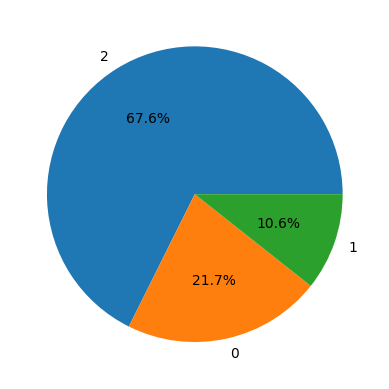

In [ ]:
plt.pie(df['rating'].value_counts().values,
        labels = df['rating'].value_counts().index,
        autopct='%1.1f%%')
plt.show()

Візуалізуємо к-ть унікальних записів кожної категорії рейтингу:

In [ ]:
fig = px.bar(df, x=df['rating'].unique(), y=df['rating'].value_counts())
fig.update_layout(xaxis_title="Ratings", yaxis_title="Count")
fig.show()

Колонка "Ефективність".

In [ ]:
df['effectiveness'].unique()

array(['Highly Effective', 'Marginally Effective', 'Ineffective',
       'Considerably Effective', 'Moderately Effective'], dtype=object)

Створимо функцію, яка це нормалізує, привівши у значення 0,1,2:

In [ ]:
def prepare_effectiveness(effectiveness):
  if effectiveness == 'Highly Effective' or effectiveness == 'Considerably Effective':
    return 2
  elif effectiveness == 'Marginally Effective' or effectiveness == 'Moderately Effective':
    return 1
  else:
    return 0

Застосуємо:

In [ ]:
df['effectiveness'] = df['effectiveness'].apply(prepare_effectiveness)

Візуалізуємо круговою діаграмою кількості кожної категорії:

In [ ]:
df['effectiveness'].value_counts()

2    2973
1     832
0     327
Name: effectiveness, dtype: int64

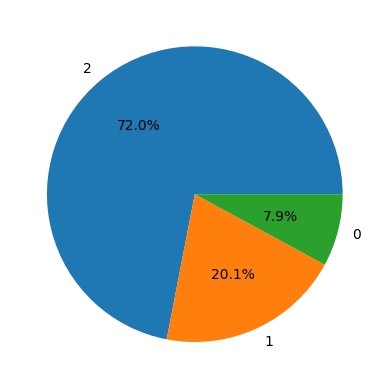

In [ ]:
plt.pie(df['effectiveness'].value_counts().values,
        labels = df['effectiveness'].value_counts().index,
        autopct='%1.1f%%')
plt.show()

Колонка sideEffects ("побічні ефекти").

In [ ]:
df['sideEffects'].unique()

array(['Mild Side Effects', 'Severe Side Effects', 'No Side Effects',
       'Extremely Severe Side Effects', 'Moderate Side Effects'],
      dtype=object)

Аналогічно до попередніх колонок, нормалізуємо, перетворивши значення колонки у 3 категорії: 0, 1, 2.

In [ ]:
def prepare_side_effects(sideEffect):
  if sideEffect == 'Severe Side Effects' or sideEffect == 'Extremely Severe Side Effects':
    return 2
  elif sideEffect == 'Mild Side Effects' or sideEffect == 'Moderate Side Effects':
    return 1
  else:
    return 0

Застосуємо функцію:

In [ ]:
df['sideEffects'] = df['sideEffects'].apply(prepare_side_effects)

Побудуємо кругову діаграму кількості кожної категорії:

In [ ]:
df['sideEffects'].value_counts()

1    2195
0    1193
2     744
Name: sideEffects, dtype: int64

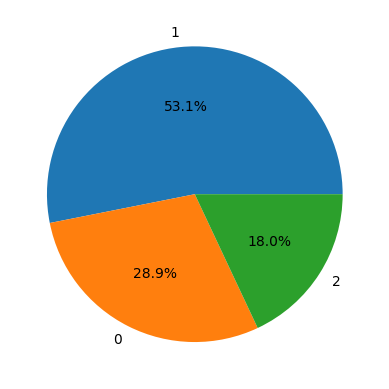

In [ ]:
plt.pie(df['sideEffects'].value_counts().values,
        labels = df['sideEffects'].value_counts().index,
        autopct='%1.1f%%')
plt.show()

### Поділ підготовлених даних на train/test

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df['overallReview'].to_numpy(), df['rating'].to_numpy(), random_state=42)

# Навчання моделі

## Створення моделей

**RNN**

In [ ]:
def create_model_rnn(layers, units, dropout, learning_rate, ngrams):
  # cтворюємо порожню модель типу Sequential
  model = Sequential()

  # cтворюємо кодер для перетворення тексту у вектори та пристосовуємо його до навчальних даних
  encoder = TextVectorization(ngrams=ngrams)
  encoder.adapt(X_train)

  # додаємо кодер до моделі для автоматичного перетворення тексту у вектори
  model.add(encoder)

  # додаємо шар Embedding для перетворення векторів слів у вектори фіксованої довжини
  model.add(Embedding(input_dim=len(encoder.get_vocabulary()), output_dim=64, mask_zero=True))

  # додаємо рекурентний шар SimpleRNN з випадковим вибором зразків для кожного навчального пакету
  for i in range(layers):
    if i == layers-1:
      model.add(SimpleRNN(units))
      model.add(Dropout(dropout))
      break

    model.add(SimpleRNN(units, return_sequences=True))
    model.add(Dropout(dropout))

  # додаємо повнозв'язаний шар Dense з активацією ReLU
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(0.1))

  # додаємо повнозв'язаний шар Dense з активацією softmax для класифікації
  model.add(Dense(len(class_names), activation='softmax'))

  # компілюємо модель з оптимізатором Adam, функцією втрат SparseCategoricalCrossentropy та метрикою точності
  model.compile(optimizer=Adam(learning_rate), loss=SparseCategoricalCrossentropy(), metrics=['accuracy'])

  return model


**GRU**

In [ ]:
def create_model_gru(layers, units, dropout, learning_rate, ngrams):
  # створюємо порожню модель Sequential
  model = Sequential()

  # створюємо кодер для перетворення тексту у вектори та пристосовуємо його до навчальних даних
  encoder = TextVectorization(ngrams=ngrams)
  encoder.adapt(X_train)

  # додаємо кодер до моделі для автоматичного перетворення тексту у вектори
  model.add(encoder)

  # додаємо шар Embedding для перетворення векторів слів у вектори фіксованої довжини
  model.add(Embedding(input_dim=len(encoder.get_vocabulary()), output_dim=64, mask_zero=True))

  # додаємо рекурентний шар GRU з випадковим вибором зразків для кожного навчального пакету
  for i in range(layers):
    if i == layers-1:
      model.add(GRU(units))
      model.add(Dropout(dropout))
      break

    model.add(GRU(units, return_sequences=True))
    model.add(Dropout(dropout))

  # додаємо повнозв'язаний шар Dense
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(0.1))

  # додаємо повнозв'язаний шар Dense з активацією softmax для класифікації
  model.add(Dense(len(class_names), activation='softmax'))

  # компілюємо модель з оптимізатором Adam, функцією втрат SparseCategoricalCrossentropy та метрикою точності
  model.compile(optimizer=Adam(learning_rate), loss=SparseCategoricalCrossentropy(), metrics=['accuracy'])

  return model

**LSTM**

In [ ]:
def create_model_lstm(layers, units, dropout, learning_rate, ngrams):
  # створюємо порожню модель Sequential
  model = Sequential()

  # створюємо кодер для перетворення тексту у вектори та пристосовуємо його до навчальних даних
  encoder = TextVectorization(ngrams=ngrams)
  encoder.adapt(X_train)

  # додаємо кодер до моделі для автоматичного перетворення тексту у вектори
  model.add(encoder)

  # додаємо шар Embedding для перетворення векторів слів у вектори фіксованої довжини
  model.add(Embedding(input_dim=len(encoder.get_vocabulary()), output_dim=64, mask_zero=True))

  # додаємо рекурентний шар LSTM з випадковим вибором зразків для кожного навчального пакету
  for i in range(layers):
    if i == layers-1:
      model.add(LSTM(units))
      model.add(Dropout(dropout))
      break

    model.add(LSTM(units, return_sequences=True))
    model.add(Dropout(dropout))

  # додаємо повнозв'язаний шар Dense
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(0.1))

  # додаємо повнозв'язаний шар Dense з активацією softmax для класифікації
  model.add(Dense(len(class_names), activation='softmax'))

  # компілюємо модель з оптимізатором Adam, функцією втрат SparseCategoricalCrossentropy та метрикою точності
  model.compile(optimizer=Adam(learning_rate), loss=SparseCategoricalCrossentropy(), metrics=['accuracy'])

  return model

**Bert**

BERT (Bidirectional Encoder Representations from Transformers) є потужним методом для роботи з текстом, який зазвичай використовується в задачах обробки природної мови (NLP). Така модель використовує трансформери та бідирекційність для ефективного представлення тексту, здатного до використання у широкому спектрі завдань NLP без додаткового навчання.

In [ ]:
def create_model_bert(layers, units, dropout, learning_rate, ngrams):
  # вхідний шар для тексту
  text_input = Input(shape=(), dtype=tf.string)

  # завантажуємо модель для попередньої обробки тексту з використанням BERT
  preprocessing_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
  encoder_inputs = preprocessing_layer(text_input)

  # завантажуємо предобучену модель BERT
  bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1", trainable=True)

  # отримуємо виходи з моделі BERT
  outputs = bert_encoder(encoder_inputs)
  net = outputs['pooled_output']

  # додаємо Dropout для регуляризації
  net = Dropout(0.1)(net)
  # додаємо повнозв'язаний шар для класифікації
  net = Dense(len(class_names), activation='softmax')(net)
  # створюємо модель вказуючи вхідний шар і вихідний шар
  model = tf.keras.Model(text_input, net)

  # компілюємо модель з оптимізатором Adam, функцією втрат SparseCategoricalCrossentropy та метрикою точності
  model.compile(optimizer=Adam(learning_rate), loss=SparseCategoricalCrossentropy(), metrics=['accuracy'])

  return model


Попередньо було підібрано оптимальні параметри Байєсовим оптимізатором. Навчання моделей:

In [ ]:
models = [{"name": 'RNN', "build_fn": create_model_rnn}, {"name": 'GRU', "build_fn": create_model_gru}, {"name": 'LSTM', "build_fn": create_model_lstm}, {"name": 'BERT', "build_fn": create_model_bert}]

Загальний код:

In [ ]:
def models_training(title):
  print(title, end='\n\n')
  for x in models:
    name = x["name"]
    build_fn = x["build_fn"]

    print(f"{name} model")

    # classifier = KerasClassifier(build_fn=build_fn)

    # searchcv = BayesSearchCV(
    #   classifier,
    #   {
    #       'layers': (1, 3),
    #       'units': [32, 64, 128],
    #       'dropout': [0.1, 0.2, 0.3, 0.4],
    #       'learning_rate': [1e-4, 1e-3, 1e-2, 0.1],
    #       'ngrams': (1, 3),
    #       'epochs': (5, 12),
    #       'batch_size': [32, 64, 128],
    #   },
    #   n_iter=10,
    #   cv=2,
    #   verbose=2,
    #   # scoring=make_scorer(cohen_kappa_score)
    # )

    # searchcv.fit(X_train, y_train, validation_data=(X_test, y_test), class_weight=class_weight)

    # model = build_fn(layers=searchcv.best_params_['layers'], units=searchcv.best_params_['units'], dropout=searchcv.best_params_['dropout'], learning_rate=searchcv.best_params_['learning_rate'], ngrams=searchcv.best_params_['ngrams'])
    # history = model.fit(X_train, y_train, epochs=searchcv.best_params_['epochs'], batch_size=searchcv.best_params_['batch_size'], validation_data=(X_test, y_test), class_weight=class_weight, verbose=0)

    # print('Best params:', searchcv.best_params_)

    model = build_fn(layers=2, units=64, dropout=0.2, learning_rate=1e-3, ngrams=2)
    history = model.fit(X_train, y_train, epochs=5, batch_size=128, validation_data=(X_test, y_test), class_weight=class_weight, verbose=0)

    display_metrics(model)
    display_learning_curves(history, name)

## Передбачення Rating

Навчання моделей, побудову графіків навчання було здійснено для всіх розглянутих моделей (RNN, GRU, LSTM, BERT).

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df['overallReview'].to_numpy(), df['rating'].to_numpy(), random_state=42)
class_weight = get_class_weights(df['rating'])

Overall rating prediction

RNN model
33/33 [==============================] - 6s 165ms/step
              precision    recall  f1-score   support

           0       0.25      0.49      0.33       208
           1       0.13      0.35      0.19       100
           2       0.77      0.37      0.50       725

    accuracy                           0.39      1033
   macro avg       0.38      0.40      0.34      1033
weighted avg       0.60      0.39      0.44      1033

Accuracy score:  0.39303000968054214
Balanced accuracy:  0.40380636604774534
F1 score:  0.3394886507053914
ROC_AUC:  0.5618579399866128
Kappa score:  0.07561719144709245


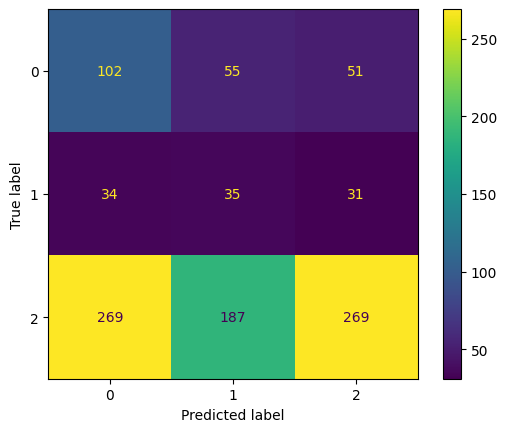

GRU model
33/33 [==============================] - 3s 21ms/step
              precision    recall  f1-score   support

           0       0.34      0.37      0.36       208
           1       0.11      0.46      0.17       100
           2       0.81      0.41      0.55       725

    accuracy                           0.41      1033
   macro avg       0.42      0.41      0.36      1033
weighted avg       0.65      0.41      0.47      1033

Accuracy score:  0.409486931268151
Balanced accuracy:  0.41466180371352784
F1 score:  0.3582023738552966
ROC_AUC:  0.6100628941040849
Kappa score:  0.11028621694089136


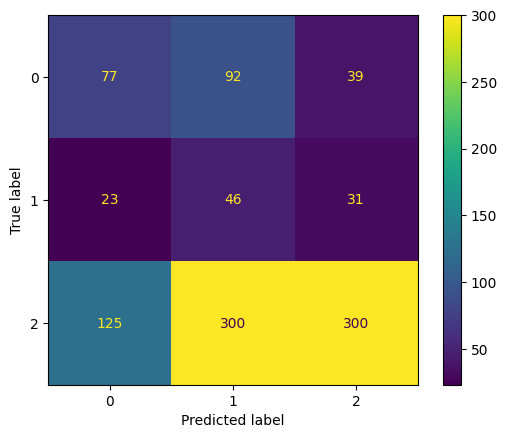

LSTM model
33/33 [==============================] - 3s 21ms/step
              precision    recall  f1-score   support

           0       0.36      0.70      0.48       208
           1       0.17      0.18      0.18       100
           2       0.82      0.60      0.69       725

    accuracy                           0.58      1033
   macro avg       0.45      0.49      0.45      1033
weighted avg       0.66      0.58      0.60      1033

Accuracy score:  0.5769603097773476
Balanced accuracy:  0.49259504862953135
F1 score:  0.4485245059492417
ROC_AUC:  0.6969867269454252
Kappa score:  0.2353630670779321


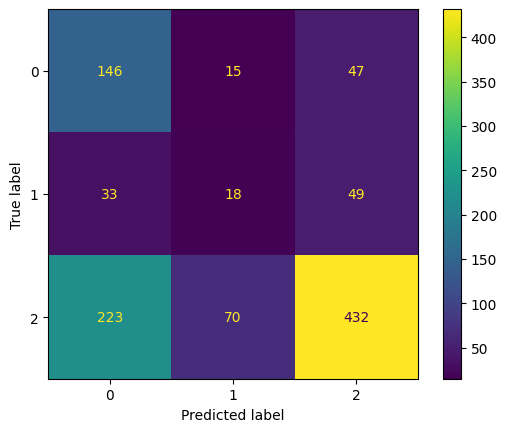

BERT model
33/33 [==============================] - 4s 105ms/step


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



              precision    recall  f1-score   support

           0       0.00      0.00      0.00       208
           1       0.10      1.00      0.18       100
           2       0.00      0.00      0.00       725

    accuracy                           0.10      1033
   macro avg       0.03      0.33      0.06      1033
weighted avg       0.01      0.10      0.02      1033

Accuracy score:  0.0968054211035818
Balanced accuracy:  0.3333333333333333
F1 score:  0.05889281507656066
ROC_AUC:  0.5694594376745946
Kappa score:  -0.00011207028051818391


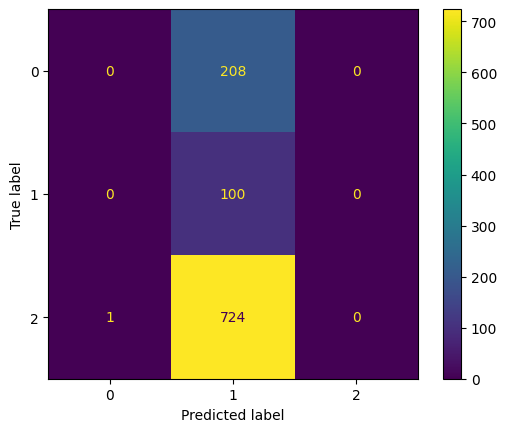

In [ ]:
models_training("Overall rating prediction")

## Передбачення Effectiveness

Аналогічно, як для оцінки Rating, навчання моделей, побудову графіків навчання було здійснено для всіх розглянутих моделей (RNN, GRU, LSTM, BERT).

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df['benefitsReview'].to_numpy(), df['effectiveness'].to_numpy(), random_state=42)
class_weight = get_class_weights(df['effectiveness'])

Effectiveness

RNN model
33/33 [==============================] - 1s 23ms/step
              precision    recall  f1-score   support

           0       0.34      0.43      0.38        81
           1       0.20      0.31      0.25       195
           2       0.78      0.65      0.71       757

    accuracy                           0.57      1033
   macro avg       0.44      0.47      0.45      1033
weighted avg       0.64      0.57      0.60      1033

Accuracy score:  0.5711519845111326
Balanced accuracy:  0.4658317453268282
F1 score:  0.44640939873220997
ROC_AUC:  0.6366645341062619
Kappa score:  0.12557324548664728


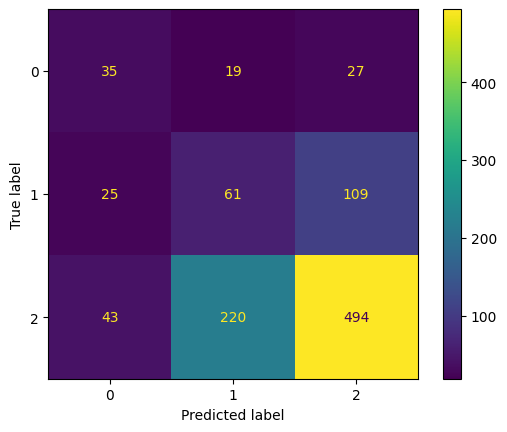

GRU model
33/33 [==============================] - 6s 103ms/step
              precision    recall  f1-score   support

           0       0.34      0.28      0.31        81
           1       0.26      0.37      0.30       195
           2       0.81      0.74      0.77       757

    accuracy                           0.63      1033
   macro avg       0.47      0.46      0.46      1033
weighted avg       0.67      0.63      0.65      1033

Accuracy score:  0.6321393998063891
Balanced accuracy:  0.4634338659584513
F1 score:  0.4620059213701815
ROC_AUC:  0.6808919229327891
Kappa score:  0.1944791016843419


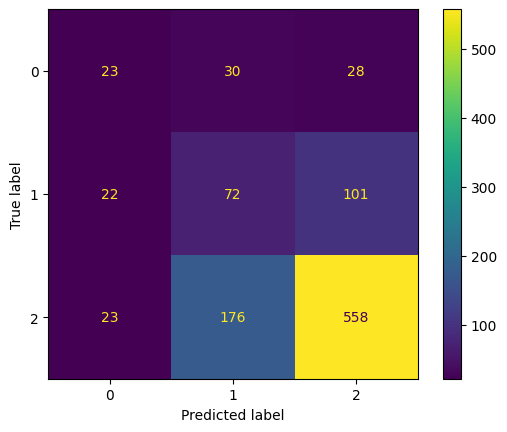

LSTM model
33/33 [==============================] - 4s 46ms/step
              precision    recall  f1-score   support

           0       0.56      0.47      0.51        81
           1       0.33      0.38      0.35       195
           2       0.82      0.80      0.81       757

    accuracy                           0.70      1033
   macro avg       0.57      0.55      0.56      1033
weighted avg       0.71      0.70      0.70      1033

Accuracy score:  0.6969990319457889
Balanced accuracy:  0.5518668642109124
F1 score:  0.558989543113738
ROC_AUC:  0.7335414621642968
Kappa score:  0.296765367332646


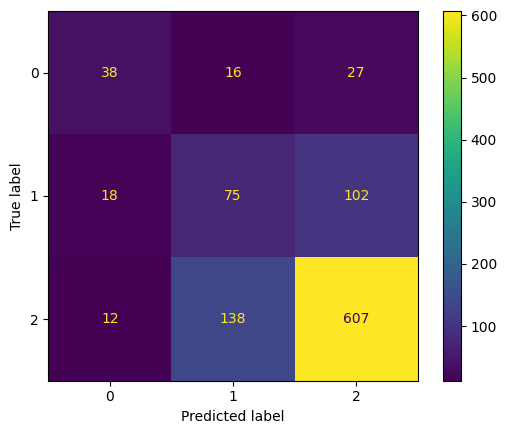

BERT model


In [ ]:
models_training("Effectiveness")

## Передбачення Side effects

Аналогічно, навчання моделей, побудову графіків навчання було здійснено для всіх розглянутих моделей (RNN, GRU, LSTM, BERT).

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df['sideEffectsReview'].to_numpy(), df['sideEffects'].to_numpy(), random_state=42)
class_weight = get_class_weights(df['sideEffects'])

Side effects

RNN model
33/33 [==============================] - 1s 33ms/step
              precision    recall  f1-score   support

           0       0.71      0.71      0.71       293
           1       0.67      0.62      0.64       553
           2       0.36      0.44      0.39       187

    accuracy                           0.61      1033
   macro avg       0.58      0.59      0.58      1033
weighted avg       0.63      0.61      0.62      1033

Accuracy score:  0.6127783155856728
Balanced accuracy:  0.5900860334315058
F1 score:  0.5828610078822903
ROC_AUC:  0.762828556916837
Kappa score:  0.37071095042140434


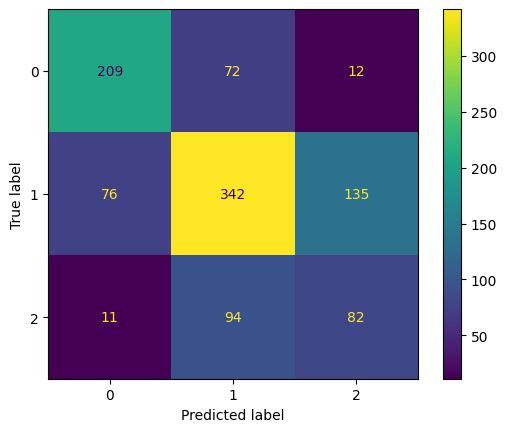

GRU model
33/33 [==============================] - 2s 8ms/step
              precision    recall  f1-score   support

           0       0.85      0.68      0.75       293
           1       0.73      0.72      0.72       553
           2       0.45      0.60      0.52       187

    accuracy                           0.69      1033
   macro avg       0.68      0.67      0.66      1033
weighted avg       0.71      0.69      0.69      1033

Accuracy score:  0.6873184898354308
Balanced accuracy:  0.6671883267656065
F1 score:  0.6645829545900336
ROC_AUC:  0.8184929940366293
Kappa score:  0.4851147947767528


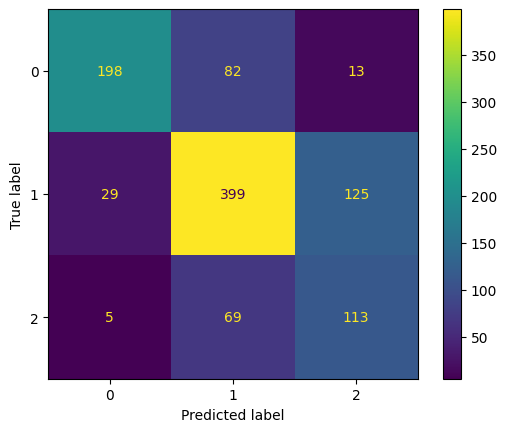

LSTM model
33/33 [==============================] - 2s 9ms/step
              precision    recall  f1-score   support

           0       0.83      0.69      0.75       293
           1       0.72      0.88      0.79       553
           2       0.68      0.41      0.51       187

    accuracy                           0.74      1033
   macro avg       0.74      0.66      0.68      1033
weighted avg       0.74      0.74      0.73      1033

Accuracy score:  0.7415295256534365
Balanced accuracy:  0.659432073453456
F1 score:  0.6849812958902133
ROC_AUC:  0.8245972451861986
Kappa score:  0.5403241935161296


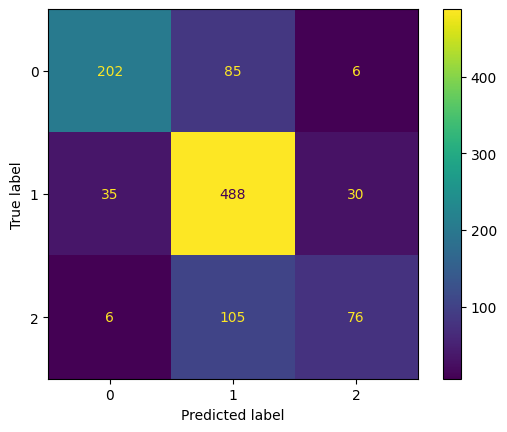

BERT model
33/33 [==============================] - 5s 125ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       293
           1       0.54      1.00      0.70       553
           2       0.00      0.00      0.00       187

    accuracy                           0.54      1033
   macro avg       0.18      0.33      0.23      1033
weighted avg       0.29      0.54      0.37      1033

Accuracy score:  0.5353339787028074
Balanced accuracy:  0.3333333333333333
F1 score:  0.23245060949978988
ROC_AUC:  0.5
Kappa score:  0.0


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



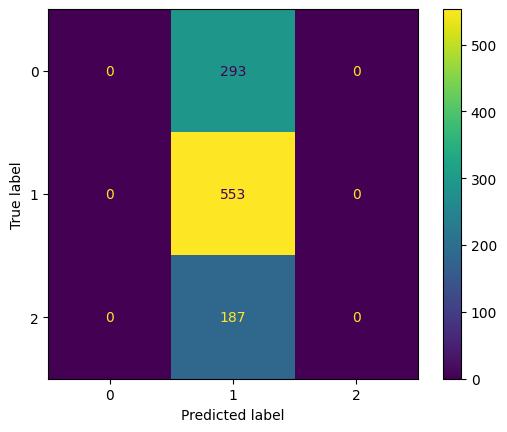

In [ ]:
models_training("Side effects")